# ICD Tokenize

The data set is a list of ICD labels and their descriptions.  
The goal is to tokenize the descriptions and train a model to predict the ICD labels.

In [1]:
! pip install transformers datasets=="2.11.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.8 MB/s eta 0:00:00


In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
from datasets import load_dataset
dataset = load_dataset("eddielin0926/chinese-icd", download_mode="force_redownload")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/295448 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/eddielin0926___parquet/eddielin0926--chinese-icd-2494d191ffcecd30/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['year', 'month', 'no', 'death', 'input_code', 'target_code', 'check', 'serial_no', 'input_0', 'input_1', 'input_2', 'input_3', 'input_4', 'target_0', 'target_1', 'target_2', 'target_3', 'target_4'],
        num_rows: 295448
    })
})


## Data

In [ ]:
import ast
import pandas as pd

df = pd.read_csv('data.csv',index_col=0)
df["catalogs"] = df["catalogs"].apply(ast.literal_eval)

display(df)

,catalogs,text
0,[急性腎衰竭],急性腎衰竭
1,[心室顫動],心室顫動
2,[菌血症],菌血症
3,[慢性腎臟疾病],慢性腎臟疾病
4,"[冠狀動脈疾病, 心臟衰竭]",冠狀動脈疾病。繞道手術後。心臟衰竭
...,...,...
623658,[腦惡性腫瘤],腦惡性腫瘤
623659,[呼吸衰竭],呼吸衰竭
623660,[肺炎],肺炎
623661,[支氣管狹窄],支氣管狹窄


Most of the descriptions are pretty short and maximum do not exceed 61.

<Axes: xlabel='text'>

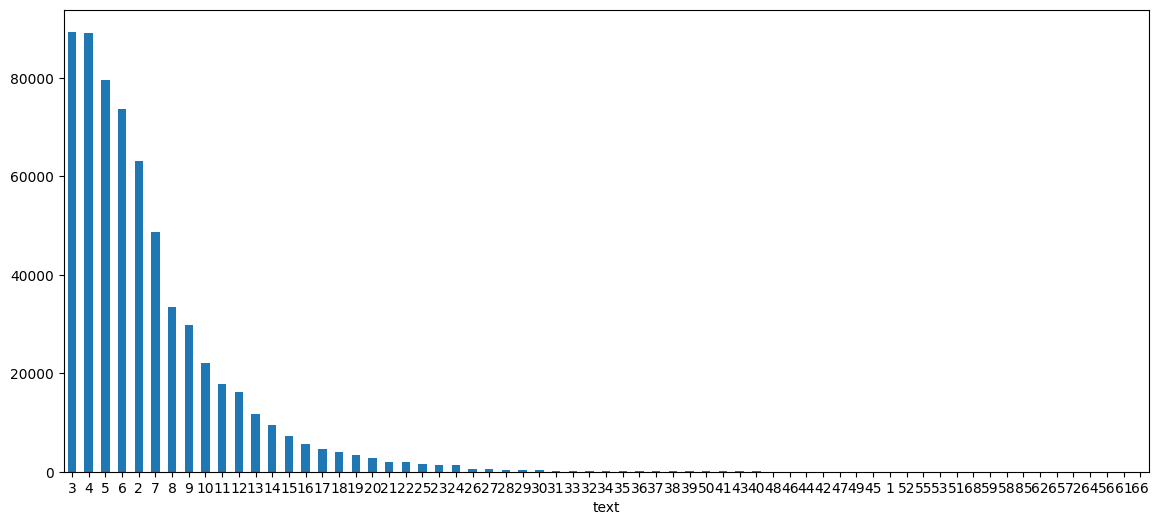

In [ ]:
display(df['text'].str.len().value_counts().plot(kind='bar', rot=0, figsize=(14, 6)))

Most of the descriptions only have one or two ICD labels.

<Axes: xlabel='catalogs'>

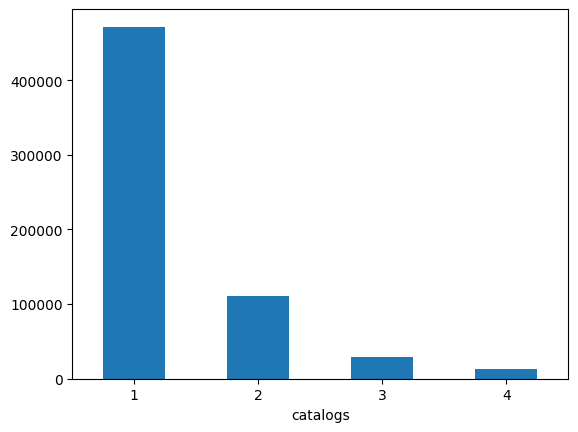

In [ ]:
df['catalogs'].apply(len).value_counts().plot(kind='bar',rot=0)

The labels are highly imbalanced and there are more than 14k labels.  
One possible solution is to trim the labels that have less than 1000 samples.

the number of labels: 14854


<Axes: >

d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 32954 (\N{CJK UNIFIED IDEOGRAPH-80BA}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 28814 (\N{CJK UNIFIED IDEOGRAPH-708E}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 33126 (\N{CJK UNIFIED IDEOGRAPH-8166}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 20663 (\N{CJK UNIFIED IDEOGRAPH-50B7}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Projec

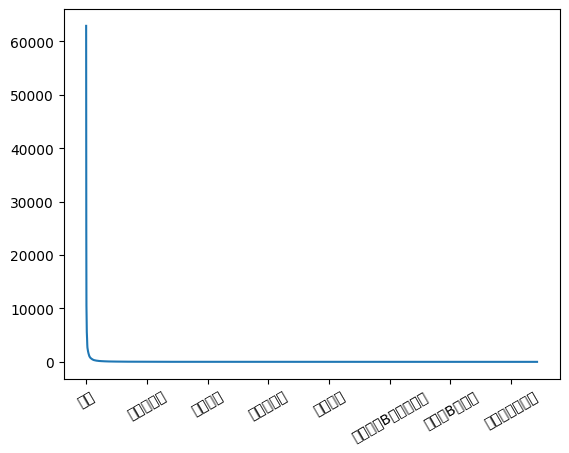

In [ ]:
from pandas import DataFrame

def count_labels(df: DataFrame):
    catalogs = df['catalogs'].tolist()
    labels = [label for catalog in catalogs for label in catalog]
    labels_count = pd.Series(labels).value_counts()
    return labels_count

counts = count_labels(df)
print(f"the number of labels: {len(counts)}")
display(counts.plot(rot=30))

100 labels account for 0.67% of the labels and 68.66% of the data


<Axes: >

d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 32954 (\N{CJK UNIFIED IDEOGRAPH-80BA}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 28814 (\N{CJK UNIFIED IDEOGRAPH-708E}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 24930 (\N{CJK UNIFIED IDEOGRAPH-6162}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 33102 (\N{CJK UNIFIED IDEOGRAPH-814E}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Projec

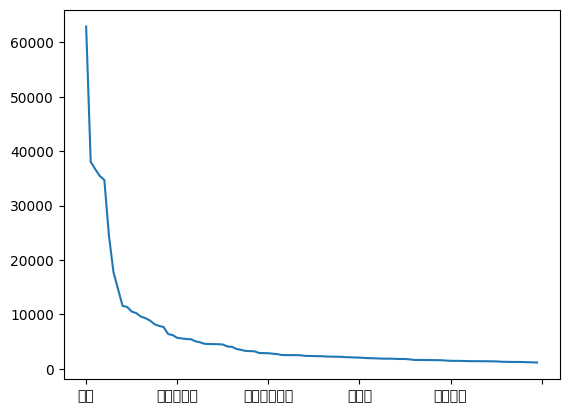

In [ ]:
def select_top(df: DataFrame, select: int):
    labels_count = count_labels(df)
    labels_count = labels_count.sort_values(ascending=False)
    majority_class = labels_count.head(select)
    return majority_class

top_classes = select_top(df, 100)
print(f"{len(top_classes)} labels account for {len(top_classes)/len(counts)*100:.2f}% of the labels and {top_classes.sum() / counts.sum() * 100:.2f}% of the data")
display(top_classes.plot())

In [ ]:
df["catalog_tuple"] = df["catalogs"].apply(tuple)
df_nodup = df.drop_duplicates(subset=['catalog_tuple', 'text'], ignore_index=True)
print(f"drop {len(df) - len(df_nodup)} duplicates, remain {len(df_nodup) / len(df) *100:.2f}% of the data")

drop 496988 duplicates, remain 20.31% of the data


the number of labels: 14854


<Axes: >

d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 34880 (\N{CJK UNIFIED IDEOGRAPH-8840}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 22739 (\N{CJK UNIFIED IDEOGRAPH-58D3}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 32954 (\N{CJK UNIFIED IDEOGRAPH-80BA}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Project\Python\icd-tokenize\.venv\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 40023 (\N{CJK UNIFIED IDEOGRAPH-9C57}) missing from current font.
  func(*args, **kwargs)
d:\Eddie\Projec

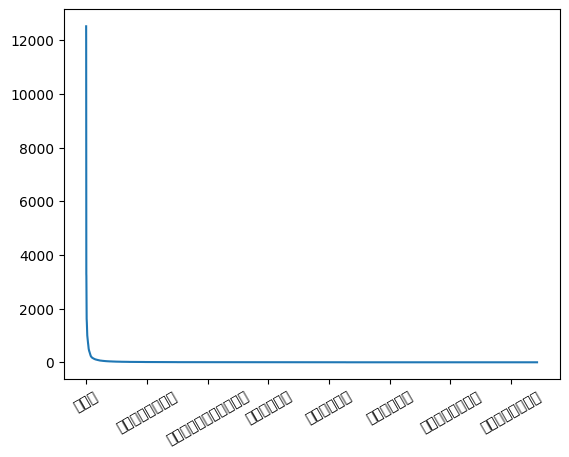

In [ ]:
counts_nodup = count_labels(df_nodup)
print(f"the number of labels: {len(counts_nodup)}")
display(counts_nodup.plot(rot=30))

10 labels account for 0.07% of the labels and 21.24% of the data


<Axes: >

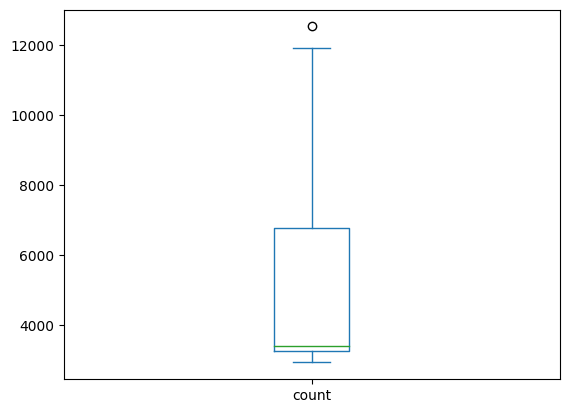

In [ ]:
top_classes_nodup = select_top(df_nodup, 10)
print(f"{len(top_classes_nodup)} labels account for {len(top_classes_nodup)/len(counts_nodup)*100:.2f}% of the labels and {top_classes_nodup.sum() / counts_nodup.sum() * 100:.2f}% of the data")
display(top_classes_nodup.plot(kind='box'))

## Pre-processing

### Multi Label Binarizer

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform(df_nodup['catalogs'])
new_df = pd.DataFrame(mlb_result, columns=mlb.classes_)
new_df['text'] = df_nodup["text"]
new_df

,18三套體,18對短臂症候群,220伏特電擊,3染色体13症,7-AMINOFLUNITRAZEPAM,AIDS,AIDS帶原者,ALK陰性退行性大細胞淋巴瘤,ALPRAZOLAM中毒,Alstrom氏症候群,...,齒齦惡性腫瘤,齒齦癌,齒齦腫瘤,齒齦鱗狀上皮癌,齒齦鱗狀細胞癌,龍發威殺蟲劑中毒,龐貝氏症,龜頭惡性腫瘤,龜頭發炎,text
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,急性腎衰竭
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,心室顫動
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,菌血症
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,慢性腎臟疾病
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,冠狀動脈疾病。繞道手術後。心臟衰竭
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,末期腎病變、冠狀動脈疾病。
126671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,胃癌肝癌
126672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,肺炎慢性阻塞性肺病.
126673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,支氣管狹窄


## Training

### Configuration
Defining some key variables that will be used later on in the training

In [ ]:
MODEL_CHECKPOINT = "bert-base-chinese"
BATCH_SIZE = 128
EPOCHS = 1
MAX_LEN = 80
LEARNING_RATE = 1e-05

### Dataset

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, classes):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.text = dataframe['text']
        self.target = dataframe[classes]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        description = self.text.iloc[index]
        item = self.tokenizer(description, truncation=True, max_length=MAX_LEN, padding='max_length')
        item['labels'] = self.target.iloc[index].values.astype(float)
        return item

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, use_fast=True)

### Split Training and Testing set

In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(new_df, test_size=0.2, random_state=13)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, mlb.classes_)
testing_set = CustomDataset(test_dataset, tokenizer, mlb.classes_)

FULL Dataset: (623663, 14855)
TRAIN Dataset: (498930, 14855)
TEST Dataset: (124733, 14855)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification")

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from transformers import TrainingArguments

model_name = MODEL_CHECKPOINT.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-icd-{len(mlb.classes_)}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit=10,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    load_best_model_at_end=True
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=training_set,
    eval_dataset=testing_set,
    tokenizer=tokenizer
)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ubuntu/Eddie/icd-tokenize/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.000600,0.000615


TrainOutput(global_step=15592, training_loss=0.012661609805598587, metrics={'train_runtime': 3642.4051, 'train_samples_per_second': 136.978, 'train_steps_per_second': 4.281, 'total_flos': 2.32467815182752e+16, 'train_loss': 0.012661609805598587, 'epoch': 1.0})